# Neural Network on Dimensionality Reduced Dataset


In [19]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import FastICA, PCA
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score,homogeneity_completeness_v_measure,silhouette_score, accuracy_score
from scipy.stats import kurtosis
from sklearn.mixture import GaussianMixture
from itertools import groupby
import operator
import keras
from sklearn.random_projection import GaussianRandomProjection

In [2]:
def get_score(model, X, y, mapper):
    pred = model.predict(X)
    pred_act = [mapper[i] for i in pred]
    return accuracy_score(pred_act, y)

# PCA

In [10]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes
    
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)
X.columns

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report'],
      dtype='object')

In [11]:
pcs = PCA(n_components=3).fit_transform(X)
ics = FastICA(20, tol=0.001, random_state=1).fit_transform(X)
grv = GaussianRandomProjection(30, random_state=4).fit_transform(X)
forest = ExtraTreesClassifier(n_estimators = 250)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
X_red = X[X.columns[indices[:15]]]

In [23]:
def ann_train(dims, input_dim, X_train, y_train, lr=0.001, epochs=200, batch_size=100, verbose=True, model=None,
              callbacks=None, val_data=None, onehot_encode=False):
    from keras.wrappers.scikit_learn import KerasClassifier
    # keras_model = build_model(dims, input_dim)
    split = 0.2
    if val_data is not None:
      split = 0
    create_model = lambda: build_model(dims, input_dim, lr=lr, mdl=model, onehot_encode=onehot_encode)
    keras_model = KerasClassifier(build_fn=create_model)
    history = keras_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                              verbose=verbose, validation_split=split, callbacks=callbacks, validation_data=val_data)
    return keras_model, history

def build_model(dims, input_dim, lr=0.001, mdl=None, onehot_encode=False):
    if mdl is not None:
      return mdl
    model = Sequential()
    model.add(Dense(dims[0], input_dim=input_dim, activation='relu'))
    for dim in dims[1:]:
      model.add(Dense(dim, activation='relu'))
    final_op = 1
    activation = 'sigmoid'
    if onehot_encode:
      final_op = 2
      activation = 'softmax'
    model.add(Dense(final_op, activation=activation))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [25]:
ann, history = ann_train((100, 50, 100),len(X.columns), X, y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 4ms/step - loss: 0.3095 - accuracy: 0.8585 - val_loss: 0.2372 - val_accuracy: 0.9064
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 0.9263 - val_loss: 0.2076 - val_accuracy: 0.9222
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.9289 - val_loss: 0.2089 - val_accuracy: 0.9204
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9367 - val_loss: 0.2043 - val_accuracy: 0.9181
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9387 - val_loss: 0.1828 - val_accuracy: 0.9313
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1331 - accuracy: 0.9463 - val_loss: 0.1835 - val_accuracy: 0.9281
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1253 - accuracy: 0.9474 - val_loss: 0.2171 - val_accuracy: 0.9136
Epoch 8/200
8

In [24]:
ann_fs, history_fs = ann_train((100, 50, 100),len(X_red.columns),X_red, y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_fs.history['accuracy'][-1])
print("Validation Accuracy: ", history_fs.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 3ms/step - loss: 0.3691 - accuracy: 0.8241 - val_loss: 0.2415 - val_accuracy: 0.9114
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.9220 - val_loss: 0.2199 - val_accuracy: 0.9213
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9299 - val_loss: 0.2208 - val_accuracy: 0.9204
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9363 - val_loss: 0.2066 - val_accuracy: 0.9258
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1386 - accuracy: 0.9415 - val_loss: 0.1927 - val_accuracy: 0.9308
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1235 - accuracy: 0.9496 - val_loss: 0.2219 - val_accuracy: 0.9199
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1179 - accuracy: 0.9501 - val_loss: 0.2023 - val_accuracy: 0.9362
Epoch 8/200
8

In [26]:
ann_pcs, history_pcs = ann_train((100, 50, 100),len(pcs[0]), pcs, y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_pcs.history['accuracy'][-1])
print("Validation Accuracy: ", history_pcs.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 3ms/step - loss: 0.3327 - accuracy: 0.8896 - val_loss: 0.2603 - val_accuracy: 0.9032
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2407 - accuracy: 0.9014 - val_loss: 0.2578 - val_accuracy: 0.9046
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2377 - accuracy: 0.9013 - val_loss: 0.2583 - val_accuracy: 0.9046
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2345 - accuracy: 0.9019 - val_loss: 0.2647 - val_accuracy: 0.8973
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2358 - accuracy: 0.9020 - val_loss: 0.2510 - val_accuracy: 0.9037
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2322 - accuracy: 0.9038 - val_loss: 0.2516 - val_accuracy: 0.9037
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2326 - accuracy: 0.9038 - val_loss: 0.2544 - val_accuracy: 0.9041
Epoch 8/200
8

In [27]:
ann_ics, history_ics = ann_train((100, 50, 100),len(ics[0]),ics, y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_ics.history['accuracy'][-1])
print("Validation Accuracy: ", history_ics.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6030 - accuracy: 0.6697 - val_loss: 0.4597 - val_accuracy: 0.8046
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2604 - accuracy: 0.9041 - val_loss: 0.2252 - val_accuracy: 0.9123
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2056 - accuracy: 0.9160 - val_loss: 0.2383 - val_accuracy: 0.8996
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1974 - accuracy: 0.9198 - val_loss: 0.2061 - val_accuracy: 0.9141
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1953 - accuracy: 0.9193 - val_loss: 0.2089 - val_accuracy: 0.9181
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1924 - accuracy: 0.9186 - val_loss: 0.2109 - val_accuracy: 0.9181
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1881 - accuracy: 0.9229 - val_loss: 0.2715 - val_accuracy: 0.8797
Epoch 8/200
8

In [28]:
ann_grv, history_grv = ann_train((100, 50, 100),len(grv[0]),grv, y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_grv.history['accuracy'][-1])
print("Validation Accuracy: ", history_grv.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 3ms/step - loss: 0.3212 - accuracy: 0.8639 - val_loss: 0.2126 - val_accuracy: 0.9258
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.9207 - val_loss: 0.2043 - val_accuracy: 0.9236
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9289 - val_loss: 0.1933 - val_accuracy: 0.9240
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1695 - accuracy: 0.9323 - val_loss: 0.2131 - val_accuracy: 0.9209
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1525 - accuracy: 0.9389 - val_loss: 0.1999 - val_accuracy: 0.9222
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9415 - val_loss: 0.1798 - val_accuracy: 0.9380
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.1458 - accuracy: 0.9412 - val_loss: 0.1801 - val_accuracy: 0.9290
Epoch 8/200
8

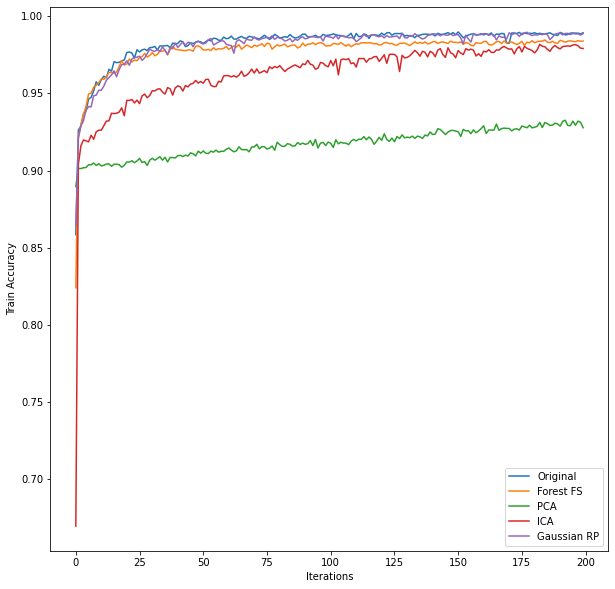

<Figure size 432x288 with 0 Axes>

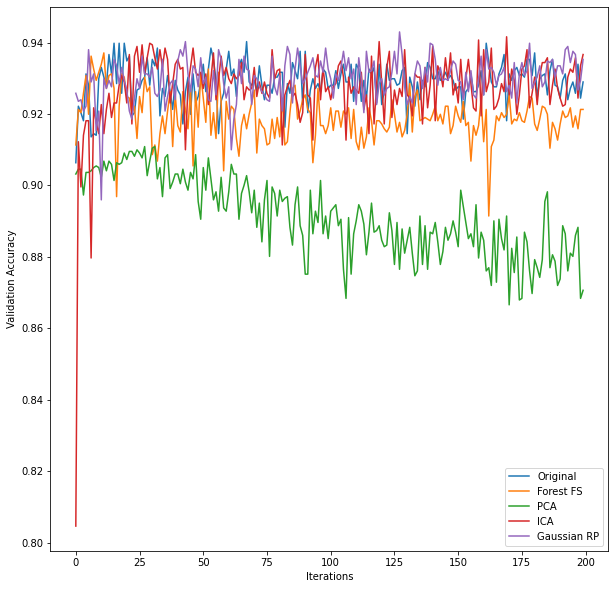

In [44]:
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'], linestyle='-', label="Original")
plt.plot(history_fs.history['accuracy'], linestyle='-', label="Forest FS")
plt.plot(history_pcs.history['accuracy'], linestyle='-', label="PCA")
plt.plot(history_ics.history['accuracy'], linestyle='-', label="ICA")
plt.plot(history_grv.history['accuracy'], linestyle='-', label="Gaussian RP")
plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Train Accuracy")
plt.show()
plt.savefig("Train-ANN.png")

plt.figure(figsize=(10,10))
plt.plot(history.history['val_accuracy'], linestyle='-', label="Original")
plt.plot(history_fs.history['val_accuracy'], linestyle='-', label="Forest FS")
plt.plot(history_pcs.history['val_accuracy'], linestyle='-', label="PCA")
plt.plot(history_ics.history['val_accuracy'], linestyle='-', label="ICA")
plt.plot(history_grv.history['val_accuracy'], linestyle='-', label="Gaussian RP")
plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.savefig("Validation-ANN.png")
plt.show()